In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gurobipy as gp
from gurobipy import GRB
import scipy
from ast import literal_eval

In [2]:
rng = np.random.default_rng(3844)

# Datasets

Simulated parameters and transcript counts for high (1.0), medium (0.5) and low (0.06) mean capture efficiencies.

'counts_x' are simulated with each cell's capture efficiency equal to the mean \
'counts_x_sampled' are simulated with each cell's capture efficiency sampled from a beta distribution

In [297]:
# mean capture efficiency for each cell
beta_high = np.array([1.0 for j in range(1000)])
params_high = pd.read_csv("params_high.csv", index_col=0)
counts_high = pd.read_csv("counts_high.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})
beta_med = np.array([0.5 for j in range(1000)])
params_med = pd.read_csv("params_med.csv", index_col=0)
counts_med = pd.read_csv("counts_med.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})
beta_low = np.array([0.06 for j in range(1000)])
params_low = pd.read_csv("params_low.csv", index_col=0)
counts_low = pd.read_csv("counts_low.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})

# sampled capture efficiency for each cell
beta_high_sampled = np.loadtxt("beta_high_sampled.csv", delimiter=",")
params_high_sampled = pd.read_csv("params_high_sampled.csv", index_col=0)
counts_high_sampled = pd.read_csv("counts_high_sampled.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})
beta_med_sampled = np.loadtxt("beta_med_sampled.csv", delimiter=",")
params_med_sampled = pd.read_csv("params_med_sampled.csv", index_col=0)
counts_med_sampled = pd.read_csv("counts_med_sampled.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})
beta_low_sampled = np.loadtxt("beta_low_sampled.csv", delimiter=",")
params_low_sampled = pd.read_csv("params_low_sampled.csv", index_col=0)
counts_low_sampled = pd.read_csv("counts_low_sampled.csv", index_col=0, converters={f'Cell-{j}': literal_eval for j in range(1000)})

# Bootstrap

In [44]:
def bootstrap_data(samples, BS=1000, thresh=1, plot=False, printing=False):
    '''
    Compute bootstrap confidence intervals on stationary distribution by 
    computing empirical distribution over multiple bootstrap samples

    samples: list of tuples of (x1, x2) counts per cell
    BS: number of bootstrap resamples
    thresh: minimum occurnces of a state in the original sample to use the CI
        otherwise replaced by [0, 1] bounds
    plot: toggle plotting CI's
    printing: toggle printing CI's
    '''

    # sample size
    n = len(samples)

    # compute maximum x1 and x2 values
    M, N = np.max(samples, axis=0)
    M, N = int(M), int(N)

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_samples = [x[1] + (N + 1)*x[0] for x in samples]

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # B bootstrap samples as B x n array
    bootstrap = rng.choice(integer_samples, size=(BS, n))

    # offset row i by (D + 1)i
    bootstrap_offset = bootstrap + np.arange(BS)[:, None]*(D + 1)

    # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
    counts = np.bincount(bootstrap_offset.ravel(), minlength=BS*(D + 1)).reshape(-1, M + 1, N + 1)

    # counts to probability
    counts = counts / n

    # compute 2.5% and 97.5% quantiles for each p(x1, x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_samples, minlength=D + 1).reshape(M + 1, N + 1)

    # set truncation bounds
    m_OB, n_OB, M_OB, N_OB = M, N, 0, 0

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            # below: replace
            if sample_counts[x1, x2] < thresh:
                bounds[:, x1, x2] = [0.0, 1.0]
            # above: update truncation
            else:
                # check if smaller than current min
                if x1 < m_OB:
                    m_OB = x1
                if x2 < n_OB:
                    n_OB = x2
                # check if larger than current max
                if x1 > M_OB:
                    M_OB = x1
                if x2 > N_OB:
                    N_OB = x2

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                # within truncation: green CI lines
                if (x1 >= m_OB) and (x2 >= n_OB) and (x1 <= M_OB) and (x2 <= N_OB):
                    color = "green"
                else:
                    color = "red"
                axs[x1, x2].hist(counts[:, x1, x2]);
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color=color)
                axs[x1, x2].axvline(bounds[1, x1, x2], color=color)

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

    if printing:
        print(f"Box truncation: [{m_OB}, {M_OB}] x [{n_OB}, {N_OB}]")

    results =  {
        'samples': samples,
        'sample_counts': sample_counts,
        'joint': bounds,
        'm_OB': m_OB,
        'n_OB': n_OB,
        'M_OB': M_OB,
        'N_OB': N_OB
    }

    return results

# Optimization

In [36]:
def B(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    '''Compute (1 / n) sum j = 1 to n of P(X1_OB, X2_OB | X1_OG, X2_OG, Beta_j): product of binomials.'''

    val = 0.0

    # compute binomial probability
    if (x1_OB <= x1_OG) and (x2_OB <= x2_OG):

        bin_coef_x1 = scipy.special.comb(x1_OG, x1_OB)
        bin_coef_x2 = scipy.special.comb(x2_OG, x2_OB)

        for beta_j in beta:

            p1 = beta_j**x1_OB * (1 - beta_j)**(x1_OG - x1_OB)
            p2 = beta_j**x2_OB * (1 - beta_j)**(x2_OG - x2_OB)
            val += p1 * p2

        n = beta.shape[0]
        val = float(bin_coef_x1 * bin_coef_x2 * val / n)

        return val
    
    # asssume we cannot observe more counts than are present originally
    else:
        return val

In [37]:
def findTrunc(x1_OB, x2_OB, beta, thresh):
    '''
    Return the first pair of states (x1_OG, x2_OG) which
    have B(x1_OB, x2_OB, x1_OG, x2_OG, beta) < thresh
    '''

    x1_OG, x2_OG = x1_OB, x2_OB
    bp = 1
    while bp > thresh:
        
        # increment
        x1_OG += 1
        x2_OG += 1

        # compute
        bp = B(x1_OB, x2_OB, x1_OG, x2_OG, beta)

    return x1_OG, x2_OG

In [369]:
def preComputeTruncation(M, N, beta, thresh):
    '''
    Compute M x N values of original truncations

    M, N: shape of observed pairs that truncations are computed for
    beta: capture efficiency vector
    thresh: threshold for trunction
    '''
    truncations = {}
    for x1_OB in range(M):
        truncations[x1_OB] = {}
        for x2_OB in range(N):
            x1_OG, x2_OG = findTrunc(x1_OB, x2_OB, beta, thresh)
            truncations[x1_OB][x2_OB] = (x1_OG, x2_OG)

    return truncations

Functions to compute the truncation point of the 'B-method' sum over original counts.

'preComputeTruncation' allows these values to be pre-computed and passed to optimization to save time during model construction 

## Standard Method

Optimize for the minima of $k_{reg}$, terminating early if a non-zero lower bound is obtained

In [ ]:
def optimization_min(bounds, beta, truncations, K=100, silent=True,
                     print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                     MIPGap=0.05, time_limit=300, BestBdThresh=0.0001):
    '''
    Minimize k_reg subject to constraints, terminating early if non-zero lower
    bound is obtained

    bounds: contains 2 x M x N array of confidence interval bounds on stat. dist. of system
            and observed truncation information
    beta: capture efficiency vector
    truncations: pre-computed dict of original truncations

    K: fixed upper bound on reaction rate constants
    silent: toggle printing of optimization status
    print_solution: toggle for printing optimization solution
    print_truncation: toggle for printing truncation information
    thresh_trunc: threshold on B coefficients for original truncation
    MIPGap: GUROBI parameter
    time_limit: time limit on optimization before termination (5 min default)
    BestBdThresh: size of non-zero lower bound on k_reg needed to terminate early
    '''

    # create model
    md = gp.Model('birth-death-regulation-capture-efficiency')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set time limit: 5 minute default
    md.Params.TimeLimit = time_limit

    # optimization settings
    md.Params.MIPGap = MIPGap

    '''experimental'''
    # aggressive presolve
    md.Params.Presolve = 2
    # focus on lower bound of objective: allows early termination
    md.Params.MIPFocus = 3

    # set threshold on BestBd for termination
    md.Params.BestBdStop = BestBdThresh

    # State space truncations

    # observed truncations: computed during bootstrap
    m_OB = bounds['m_OB']
    n_OB = bounds['n_OB']
    M_OB = bounds['M_OB']
    N_OB = bounds['N_OB']

    # find largest original truncations: (pre)computed by thresholding coefficients
    M_OG, N_OG = 0, 0
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):
            try:
                # lookup
                m_OG, n_OG = truncations[x1_OB][x2_OB]
            except KeyError:
                # compute if not available
                m_OG, n_OG = findTrunc(x1_OB, x2_OB, beta, thresh_trunc)
                # store
                truncations[x1_OB][x2_OB] = (m_OG, n_OG)

            # update largest values
            if m_OG > M_OG:
                M_OG = m_OG
            if n_OG > N_OG:
                N_OG = n_OG

    if print_truncation:
        print(f"Observed counts: [{m_OB}, {M_OB}] x [{n_OB}, {N_OB}] \nOriginal counts: [0, {M_OG - 1}] x [0, {N_OG - 1}]")

    # variables

    # stationary distribution: original counts (size = largest truncation)
    p = md.addMVar(shape=(M_OG, N_OG), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # fix k_deg_2 = 1 for identifiability
    md.addConstr(rates['k_deg_2'] == 1)

    # stationary distribution bounds: for each observed count
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):

            # individual truncation: lookup from pre-computed dict
            m_OG, n_OG = truncations[x1_OB][x2_OB]

            sum_expr = gp.quicksum([B(x1_OB, x2_OB, x1_OG, x2_OG, beta) * p[x1_OG, x2_OG] for x1_OG in range(m_OG) for x2_OG in range(n_OG)])
            md.addConstr(sum_expr >= bounds['joint'][0, x1_OB, x2_OB], name=f"B lb {x1_OB}, {x2_OB}")
            md.addConstr(sum_expr <= bounds['joint'][1, x1_OB, x2_OB], name=f"B ub {x1_OB}, {x2_OB}")

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # stationary Qp=0 equations for all relevant variables
    for x1_OG in range(M_OG - 1):
        for x2_OG in range(N_OG - 1):
            if x1_OG == 0:
                x1_zero = 0
            else:
                x1_zero = 1
            if x2_OG == 0:
                x2_zero = 0
            else:
                x2_zero = 1

            md.addConstr(
                # remove terms when x1 or x2 = 0 since not in equation
                # so multiply by toggle
                rates['k_tx_1'] * x1_zero * p[x1_OG - 1, x2_OG] + \
                rates['k_tx_2'] * x2_zero * p[x1_OG, x2_OG - 1] + \
                rates['k_deg_1'] * (x1_OG + 1) * p[x1_OG + 1, x2_OG] + \
                rates['k_deg_2'] * (x2_OG + 1) * p[x1_OG, x2_OG + 1] + \
                rates['k_reg'] * (x1_OG + 1) * (x2_OG + 1) * p[x1_OG + 1, x2_OG + 1] - \
                (rates['k_tx_1'] + rates['k_tx_2'] + \
                 rates['k_deg_1'] * x1_OG + rates['k_deg_2'] * x2_OG + \
                 rates['k_reg'] * x1_OG * x2_OG) * p[x1_OG, x2_OG] == 0,
                name=f"Equation {x1_OG}, {x2_OG}"
                )

    # status of optimization
    status_codes = {1: 'LOADED',
                    2: 'OPTIMAL',
                    3: 'INFEASIBLE',
                    4: 'INF_OR_UNBD',
                    5: 'UNBOUNDED',
                    6: 'CUTOFF',
                    7: 'ITERATION_LIMIT',
                    8: 'NODE_LIMIT',
                    9: 'TIME_LIMIT',
                    10: 'SOLUTION_LIMIT',
                    11: 'INTERRUPTED',
                    12: 'NUMERIC',
                    13: 'SUBOPTIMAL',
                    14: 'INPROGRESS',
                    15: 'USER_OBJ_LIMIT'}

    # solution dict
    solution = {
        'k_tx_1': "v",
        'k_tx_2': "v",
        'k_deg_1': "v",
        'k_deg_2': 1,
        'k_reg': None
    }

    # Optimize

    # set objective: minimize interaction parameter
    md.setObjective(rates['k_reg'], GRB.MINIMIZE)

    # attempt to optimize
    try:
        md.optimize()
        min_val = md.ObjVal
    except:
        min_val = None

    # report status
    status_min = status_codes[md.status]

    # record
    solution['k_reg'] = [min_val, status_min]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'k_reg':
                if val[1] == 'USER_OBJ_LIMIT':
                    print(f"{key} non-zero lower bound found, early termination status {val[1]}")
                else:
                    print(f"{key} lower bound {val[0]}, status {val[1]}")
            elif val == "v":
                print(f"{key} variable, not optimized")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

### Example

In [305]:
# pre-compute truncations for a given capture efficiency
truncations_high = preComputeTruncation(30, 30, beta_high, 10**-6)
truncations_med = preComputeTruncation(30, 30, beta_med, 10**-6)
truncations_low = preComputeTruncation(30, 30, beta_low, 10**-6)

In [254]:
# select a gene pair: 18, 24, 45, 47, 52, 58, 59 (some examples where not all counts of a gene are = 0)
i = 59

# select sample
samples_high = list(counts_high.loc[f'Gene-pair-{i}'])

# bootstrap
bounds_high = bootstrap_data(samples_high, BS=1000, thresh=10, printing=True)

Box truncation: [0, 11] x [0, 3]


In [255]:
# optimize
solution_high_min = optimization_min(bounds_high, beta_high, truncations_high, K=100, silent=False,
                     print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                     MIPGap=0.05, time_limit=300, BestBdThresh=0.0001)

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter Presolve to value 2
Set parameter MIPFocus to value 3
Set parameter BestBdStop to value 0.0001
Observed counts: [0, 11] x [0, 3] 
Original counts: [0, 11] x [0, 3]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 98 rows, 53 columns and 145 nonzeros
Model fingerprint: 0x32d60160
Model has 33 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [5e-03, 1e+00]
Presolve removed 97 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presolve 

In [256]:
# true interaction value > 0
params_high.loc[f'Gene-pair-{i}']

k_tx_1     3.212642
k_tx_2     2.671750
k_deg_1    0.234658
k_deg_2    0.612194
k_reg      6.121941
Name: Gene-pair-59, dtype: float64

### Example

In [306]:
# pre-compute truncations for a given capture efficiency
truncations_high_sampled = preComputeTruncation(30, 30, beta_high_sampled, 10**-6)
truncations_med_sampled = preComputeTruncation(30, 30, beta_med_sampled, 10**-6)
truncations_low_sampled = preComputeTruncation(30, 30, beta_low_sampled, 10**-6)

In [304]:
# select a gene pair
i = 2

# select sample
samples_high_sampled = list(counts_high_sampled.loc[f'Gene-pair-{i}'])

# bootstrap
bounds_high_sampled = bootstrap_data(samples_high_sampled, BS=1000, thresh=10, printing=True)

Box truncation: [0, 1] x [1, 18]


In [307]:
# optimize
solution_high_sampled_min = optimization_min(bounds_high_sampled, beta_high_sampled, truncations_high_sampled, K=100, silent=False,
                     print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                     MIPGap=0.05, time_limit=300, BestBdThresh=0.0001)

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter Presolve to value 2
Set parameter MIPFocus to value 3
Set parameter BestBdStop to value 0.0001
Observed counts: [0, 1] x [1, 18] 
Original counts: [0, 7] x [0, 24]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 74 rows, 205 columns and 2933 nonzeros
Model fingerprint: 0x40b1bf7b
Model has 168 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-07, 1e+00]
  QMatrix range    [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [4e-03, 1e+00]
Presolve removed 52 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presol

In [308]:
# true interaction value > 0
params_high_sampled.loc[f'Gene-pair-{i}']

k_tx_1     2.839879
k_tx_2     5.435977
k_deg_1    0.539173
k_deg_2    0.308001
k_reg      3.080008
Name: Gene-pair-2, dtype: float64

## Hypothesis Method

Test feasibility under the assumption of no interaction, infeasibility suggests the assumption is false but may be due to other factors (wrong model, etc)

In [294]:
def optimization_B_hyp(bounds, beta, truncations, K=100, silent=True,
                       print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                       time_limit=300):
    '''
    Feasibility test under assumption of no interaction: k_reg = 0

    bounds: 2 x M x N array of confidence interval bounds on stat. dist. of system
    beta: capture efficiency
    truncationMatrix: pre-computed threshold truncations on original counts
    
    K: fixed upper bound on reaction rate constants
    silent: toggle printing of optimization status
    print_solution: toggle for printing optimization solution
    print_truncation: toggle for printing truncations used
    thresh_trunc: threshold on B coefficients for original truncation
    time_limit: limit on optimization time before termination
    '''

    # create model
    md = gp.Model('birth-death-regulation-capture-efficiency-hyp')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set time limit: 5 minute default
    md.Params.TimeLimit = time_limit

    # State space truncations

    # observed truncations: computed during bootstrap
    m_OB = bounds['m_OB']
    n_OB = bounds['n_OB']
    M_OB = bounds['M_OB']
    N_OB = bounds['N_OB']

    # find largest original truncations: (pre)computed by thresholding coefficients
    M_OG, N_OG = 0, 0
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):
            try:
                # lookup
                m_OG, n_OG = truncations[x1_OB][x2_OB]
            except KeyError:
                # compute if not available
                m_OG, n_OG = findTrunc(x1_OB, x2_OB, beta, thresh_trunc)
                # store
                truncations[x1_OB][x2_OB] = (m_OG, n_OG)

            # update largest values
            if m_OG > M_OG:
                M_OG = m_OG
            if n_OG > N_OG:
                N_OG = n_OG
    
    if print_truncation:
        print(f"Observed counts: [{m_OB}, {M_OB}] x [{n_OB}, {N_OB}] \nOriginal counts: [0, {M_OG - 1}] x [0, {N_OG - 1}]")

    # variables

    # marginal stationary distributions: original counts (size = largest truncations)
    p1 = md.addMVar(shape=(M_OG), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
    p2 = md.addMVar(shape=(N_OG), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

    # dummy joint variable to avoid triple products (as not supported by GUROBI): should be removed by presolve
    p_dummy = md.addMVar(shape=(M_OG, N_OG), vtype=GRB.CONTINUOUS, name="p_dummy", lb=0, ub=1)

    '''aggressive presolve to hopefully ensure this'''
    md.Params.Presolve = 2

    # reaction rate constants
    rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # fix k_deg_1 = 1, k_deg = 2 for identifiability
    md.addConstr(rates['k_deg_1'] == 1)
    md.addConstr(rates['k_deg_2'] == 1)

    # stationary distribution bounds: for each observed count
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):
            
            # individual truncation: lookup from pre-computed dict
            m_OG, n_OG = truncations[x1_OB][x2_OB]
            
            sum_expr = gp.quicksum([B(x1_OB, x2_OB, x1_OG, x2_OG, beta) * p1[x1_OG] * p2[x2_OG] for x1_OG in range(m_OG) for x2_OG in range(n_OG)])
            md.addConstr(sum_expr >= bounds['joint'][0, x1_OB, x2_OB], name=f"B lb {x1_OB}, {x2_OB}")
            md.addConstr(sum_expr <= bounds['joint'][1, x1_OB, x2_OB], name=f"B ub {x1_OB}, {x2_OB}")

    # distributional constraints
    md.addConstr(p1.sum() <= 1, name="Distribution x1")
    md.addConstr(p2.sum() <= 1, name="Distribution x2")

    # equate dummy joint variable to product of marginals
    for x1_OG in range(M_OG):
        for x2_OG in range(N_OG):

            md.addConstr(p_dummy[x1_OG, x2_OG] == p1[x1_OG] * p2[x2_OG], name=f"Dummy joint definition {x1_OG}, {x2_OG}")

    # CME: use dummy joint variable to avoid triple products: k_[] * p1[] * p2[]
    for x1_OG in range(M_OG - 1):
        for x2_OG in range(N_OG - 1):

            # remove terms when x's = 0 as not present in equation
            if x1_OG == 0:
                x1_zero = 0
            else:
                x1_zero = 1
            if x2_OG == 0:
                x2_zero = 0
            else:
                x2_zero = 1

            md.addConstr(
                rates['k_tx_1'] * x1_zero * p_dummy[x1_OG - 1, x2_OG] + \
                rates['k_tx_2'] * x2_zero * p_dummy[x1_OG, x2_OG - 1] + \
                rates['k_deg_1'] * (x1_OG + 1) * p_dummy[x1_OG + 1, x2_OG] + \
                rates['k_deg_2'] * (x2_OG + 1) * p_dummy[x1_OG, x2_OG + 1] - \
                (rates['k_tx_1'] + rates['k_tx_2'] + \
                rates['k_deg_1'] * x1_OG + rates['k_deg_2'] * x2_OG) * p_dummy[x1_OG, x2_OG] == 0,
                name=f"CME {x1_OG}, {x2_OG}"
                )

    # status of optimization
    status_codes = {1: 'LOADED',
                    2: 'OPTIMAL',
                    3: 'INFEASIBLE',
                    4: 'INF_OR_UNBD',
                    5: 'UNBOUNDED',
                    6: 'CUTOFF',
                    7: 'ITERATION_LIMIT',
                    8: 'NODE_LIMIT',
                    9: 'TIME_LIMIT',
                    10: 'SOLUTION_LIMIT',
                    11: 'INTERRUPTED',
                    12: 'NUMERIC',
                    13: 'SUBOPTIMAL',
                    14: 'INPROGRESS',
                    15: 'USER_OBJ_LIMIT'}

    # solution dict
    solution = {
        'status': None,
        'k_tx_1': "v",
        'k_tx_2': "v",
        'k_deg_1': 1,
        'k_deg_2': 1
    }

    # testing feasibility: simply optimize 0
    md.setObjective(0, GRB.MINIMIZE)

    # set parameter (prevents 'infeasible or unbounded' ambiguity)
    md.Params.DualReductions = 0

    # set solution limit (stop after finding 1 feasible solution)
    md.Params.SolutionLimit = 1

    try:
        md.optimize()
        status_code = md.status
    except:
        status_code = md.status

    # store result
    solution['status'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == "status":
                print(f"Model is {val}")
            elif val == "v":
                print(f"{key} variable")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

### Example

In [258]:
# select a gene pair
i = 11

# select sample
samples_med = list(counts_high.loc[f'Gene-pair-{i}'])

# bootstrap
bounds_med = bootstrap_data(samples_med, BS=1000, thresh=10, printing=True)

Box truncation: [0, 1] x [6, 35]


In [265]:
# optimize
solution_med_hyp = optimization_B_hyp(bounds_med, beta_med, truncations_med, K=100, silent=False,
                       print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                       time_limit=300)

Set parameter TimeLimit to value 300
Observed counts: [0, 1] x [6, 35] 
Original counts: [0, 21] x [0, 42]
Set parameter DualReductions to value 0
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 1015 columns and 67 nonzeros
Model fingerprint: 0x3d54481b
Model has 1948 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-12, 4e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+00]
  QRHS range       [4e-03, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.01s

Barrier solved model in 0 iterations and 0.

In [266]:
# true interaction value > 0
params_med.loc[f'Gene-pair-{i}']

k_tx_1     25.364843
k_tx_2      0.006528
k_deg_1     0.291449
k_deg_2     0.225206
k_reg       2.252062
Name: Gene-pair-11, dtype: float64

### Example

In [291]:
# select a gene pair: 33, 46, 49, 77
i = 33

# select sample
samples_low = list(counts_low.loc[f'Gene-pair-{i}'])

# bootstrap
bounds_low = bootstrap_data(samples_low, BS=1000, thresh=10, printing=True)

Box truncation: [0, 4] x [0, 1]


In [295]:
# optimize
solution_low_hyp = optimization_B_hyp(bounds_low, beta_low, truncations_low, K=100, silent=False,
                       print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                       time_limit=1200)

Set parameter TimeLimit to value 1200
Observed counts: [0, 4] x [0, 1] 
Original counts: [0, 187] x [0, 184]
Set parameter Presolve to value 2
Set parameter DualReductions to value 0
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 35157 columns and 375 nonzeros
Model fingerprint: 0xe1b2304f
Model has 69208 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-10, 2e+02]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+00]
  QRHS range       [8e-03, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2 rows an

# Data Illustrations

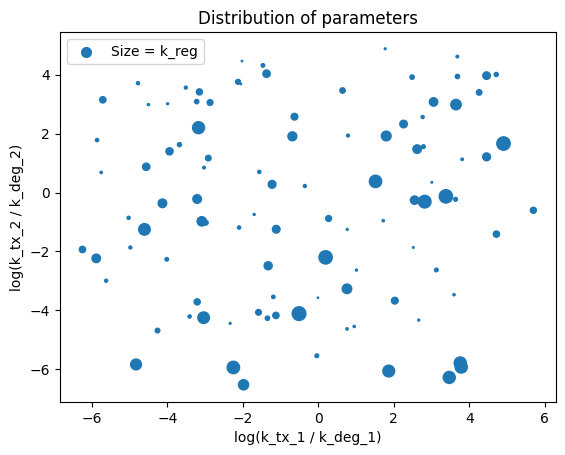

In [334]:
# select set
params = params_high

# scatter
plt.scatter(np.log(params['k_tx_1']) - np.log(params['k_deg_1']), np.log(params['k_tx_2']) - np.log(params['k_deg_2']), s=params['k_reg']**2, label="Size = k_reg")
plt.xlabel("log(k_tx_1 / k_deg_1)")
plt.ylabel("log(k_tx_2 / k_deg_2)")
plt.title(f"Distribution of parameters")
plt.legend()
plt.show()

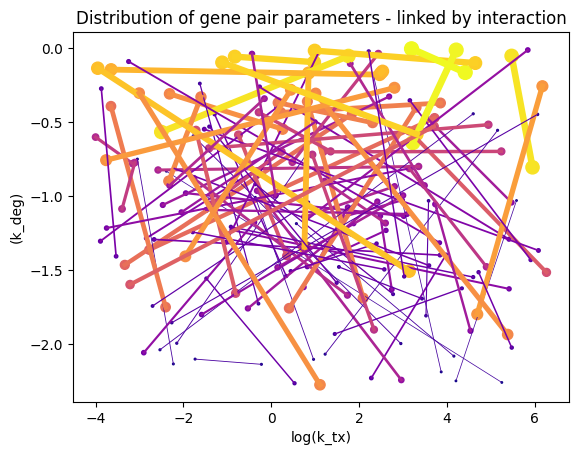

In [408]:
# select set
params = params_low

# scatter
plt.scatter(
    np.log(params['k_tx_1']),
    np.log(params['k_deg_1']),
    s=params['k_reg']**2,
    c=params['k_reg'],
    cmap=plt.cm.plasma
)
plt.scatter(
    np.log(params['k_tx_2']),
    np.log(params['k_deg_2']),
    s=params['k_reg']**2,
    c=params['k_reg'],
    cmap=plt.cm.plasma
)

for i in range(100):
    param_set = params.loc[f'Gene-pair-{i}']
    col = plt.cm.plasma(0.1 * param_set['k_reg'])
    plt.plot(
        [np.log(param_set['k_tx_1']), np.log(param_set['k_tx_2'])],
        [np.log(param_set['k_deg_1']), np.log(param_set['k_deg_2'])],
        color=col,
        linewidth=0.5 * param_set['k_reg']
    )

plt.xlabel("log(k_tx)")
plt.ylabel("(k_deg)")
plt.title("Distribution of gene pair parameters - linked by interaction")
#plt.legend()
plt.show()

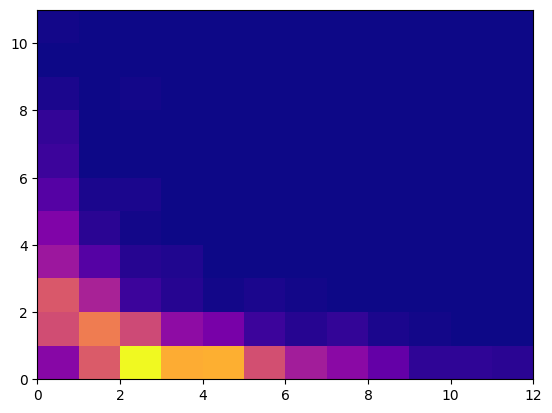

In [368]:
# select sample
counts = counts_high
i = 24

sample = list(counts.loc[f'Gene-pair-{i}'])
x1_sample = [x[0] for x in sample]
x2_sample = [x[1] for x in sample]

# plot dist
plt.hist2d(x1_sample, x2_sample, 
           bins=[range(int(np.min(x1_sample)), int(np.max(x1_sample)) + 2), range(int(np.min(x2_sample)), int(np.max(x2_sample)) + 2)],
           cmap='plasma');